# 使用SAM2处理nii格式的三维医学图像文件

#### 导入环境和确认设备
参考SAM2的demo。

In [6]:
using_colab = False
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !mkdir -p images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/cars.jpg

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

In [7]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

# select the device for computation
if torch.cuda.is_available():
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


#### 载入SAM2视频预测器

In [5]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [6]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

#### 选择nii图像
.nii.gz后缀格式的文件

In [11]:
import nibabel as nib

# 指定nii.gz文件路径
# nii_file_path = "/home/wz/Task04_Hippocampus/labelsTr/hippocampus_001.nii.gz"
# nii_file_path = "/home/wz/Task04_Hippocampus/imagesTr/hippocampus_001.nii.gz"
# nii_file_path = "/home/wz/MSD/Task07_Pancreas/labelsTr/pancreas_001.nii.gz"
nii_file_path = "/home/wz/MSD/Task07_Pancreas/imagesTr/pancreas_001.nii.gz"

# 加载NIfTI文件
img = nib.load(nii_file_path)
img_data = img.get_fdata()

# 图像信息
print(f"图像形状: {img_data.shape}")
print(f"数据类型: {img_data.dtype}")
print(f"图像范围: [{img_data.min():.2f}, {img_data.max():.2f}]")
print(f"仿射矩阵:\n{img.affine}")

图像形状: (512, 512, 110)
数据类型: float64
图像范围: [0.00, 2.00]
仿射矩阵:
[[   0.64453101    0.            0.         -329.35534668]
 [   0.            0.64453101    0.         -329.35534668]
 [   0.            0.            2.5           0.        ]
 [   0.            0.            0.            1.        ]]


将`img_data`转换为<序号>.jpg的格式，保存在`./videos/test`中。

上采样到原本的`UPSAMPLE_FACTOR`倍大小，使用双线性插值。

In [16]:
# 常量：是否保存为RGB格式（True为RGB，False为灰度图）
SAVE_AS_RGB = False

# 上采样倍数
UPSAMPLE_FACTOR = 1

# 创建输出目录
# output_dir = "./videos/test_labels"
output_dir = "./videos/test"
os.makedirs(output_dir, exist_ok=True)

# 获取三维图像的层数
num_slices = img_data.shape[2]

# 逐层转换为JPG并保存
for i in range(num_slices):
    # 提取第i层切片
    slice_data = img_data[:, :, i]
    
    # 归一化到0-255范围
    slice_min = slice_data.min()
    slice_max = slice_data.max()
    if slice_max > slice_min:
        normalized = ((slice_data - slice_min) / (slice_max - slice_min) * 255).astype(np.uint8)
    else:
        normalized = np.zeros_like(slice_data, dtype=np.uint8)
    
    # 转换为PIL图像
    img_pil = Image.fromarray(normalized)
    
    # 双线性插值上采样到4倍大小
    original_size = img_pil.size
    new_size = (original_size[0] * UPSAMPLE_FACTOR, original_size[1] * UPSAMPLE_FACTOR)
    img_pil_upsampled = img_pil.resize(new_size, Image.BILINEAR)
    
    # 根据常量选择保存格式
    if SAVE_AS_RGB:
        img_pil_upsampled = img_pil_upsampled.convert("RGB")
    
    # 保存
    output_path = os.path.join(output_dir, f"{i:05d}.jpg")
    img_pil_upsampled.save(output_path)

print(f"成功保存 {num_slices} 张JPG图像到 {output_dir}")
print(f"图像大小: {new_size}（原始大小 x {UPSAMPLE_FACTOR}）")
print(f"保存格式: {'RGB' if SAVE_AS_RGB else '灰度图'}")

成功保存 110 张JPG图像到 ./videos/test_labels
图像大小: (512, 512)（原始大小 x 1）
保存格式: 灰度图


载入并预览这些帧。

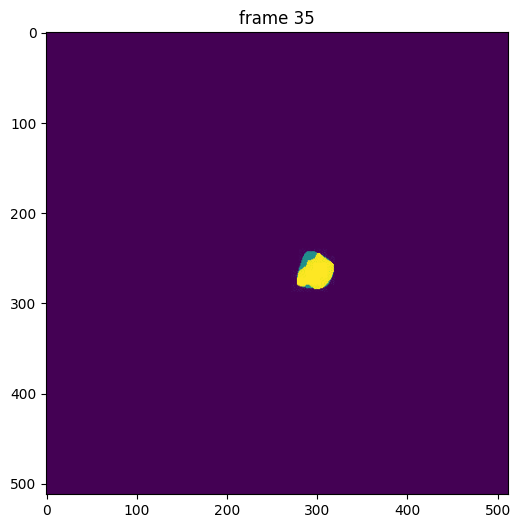

In [18]:
# `video_dir` a directory of JPEG frames with filenames like `<frame_index>.jpg`
video_dir = "./videos/test"

# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

# take a look the first video frame
frame_idx = 35
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

初始化预测器和载入图片。

In [17]:
inference_state = predictor.init_state(video_path=video_dir)

frame loading (JPEG): 100%|██████████| 35/35 [00:00<00:00, 127.84it/s]



#### 添加一个点并推理分割

/home/wz/sam2/sam2/sam2_video_predictor.py:786: UserWarning: /home/wz/sam2/sam2/_C.so: undefined symbol: _ZN3c106detail23torchInternalAssertFailEPKcS2_jS2_RKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


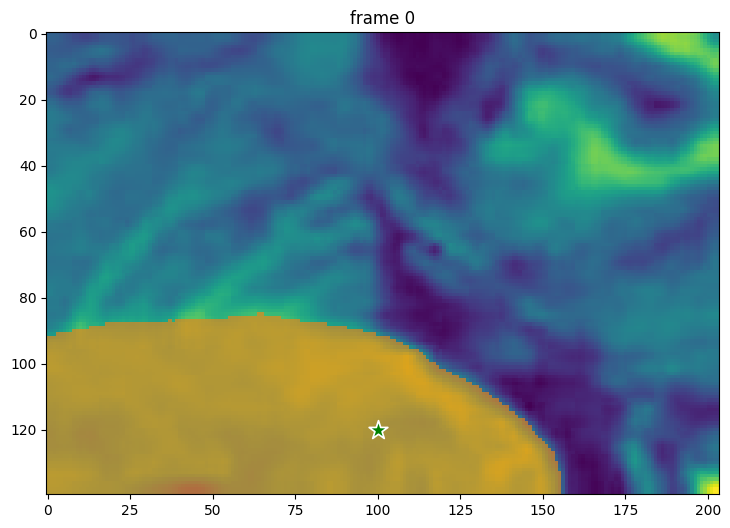

In [ ]:
ann_frame_idx = 0  # the frame index we interact with
ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

# 这里改成在[100，120]位置打点。
points = np.array([[100, 120]], dtype=np.float32)
# for labels, `1` means positive click and `0` means negative click
labels = np.array([1], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=ann_frame_idx,
    obj_id=ann_obj_id,
    points=points,
    labels=labels,
)

# show the results on the current (interacted) frame
# out_mask_logits 是最后一层的输出，应该是H*W的像素级掩码。
plt.figure(figsize=(9, 6))
plt.title(f"frame {ann_frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])

将第0帧的提示点推广到所有帧。

propagate in video: 100%|██████████| 35/35 [00:01<00:00, 30.44it/s]



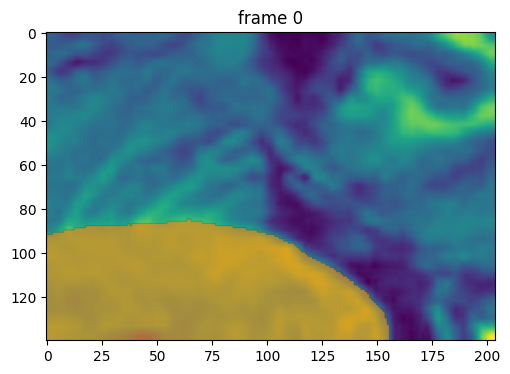

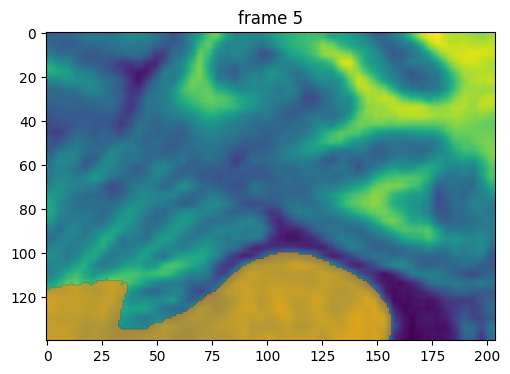

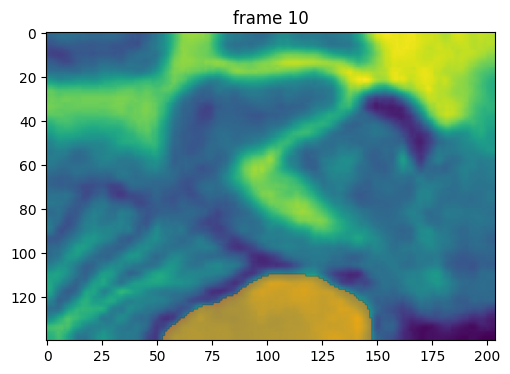

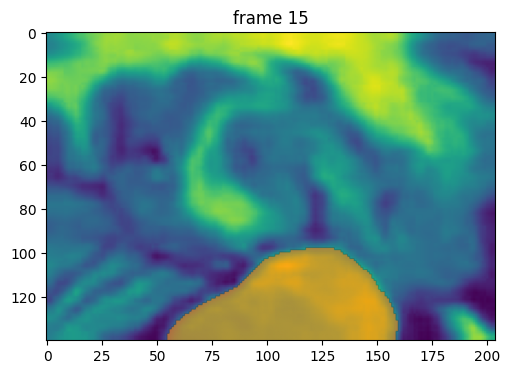

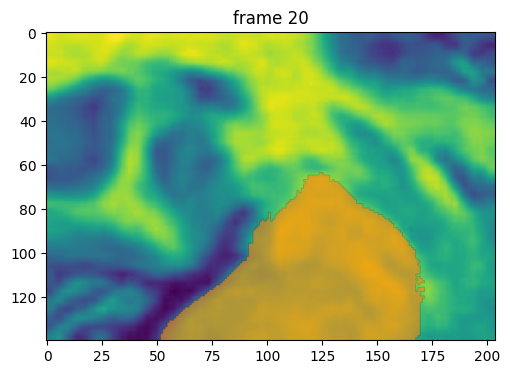

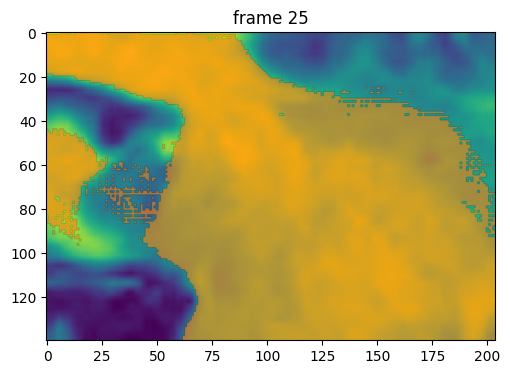

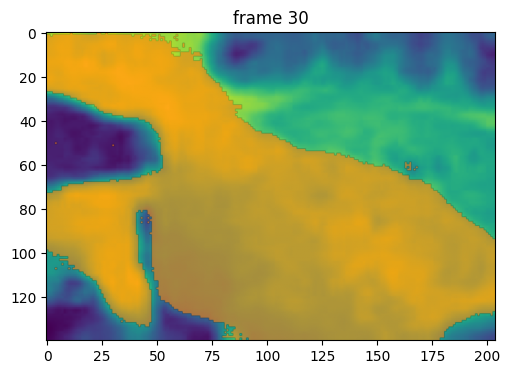

In [19]:
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

# render the segmentation results every few frames
vis_frame_stride = 5
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    plt.figure(figsize=(6, 4))
    plt.title(f"frame {out_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[out_frame_idx])))
    for out_obj_id, out_mask in video_segments[out_frame_idx].items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)